 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"></ul></div>

Superceded by Make Climatology

In [1]:
import netCDF4 as NC
import numpy as np
import matplotlib.pyplot as plt

from salishsea_tools import rivertools, river_201702, nc_tools

%matplotlib inline

In [2]:
import importlib
importlib.reload(rivertools)

<module 'salishsea_tools.rivertools' from '/ocean/sallen/allen/research/Meopar/Tools/SalishSeaTools/salishsea_tools/rivertools.py'>

In [17]:
#what type of file would you like to create?
#e.g. 'constant' - yearly average used for all months
#     'monthly' - monthly averages used for each month
rivertype = 'monthly'
bathy = '../../../nemo-forcing/grid/bathymetry_201702.nc'
# leave temperature at -99, I'm not setting it in this file

In [18]:
#get watershed fluxes from netcdf file
if rivertype == 'constant':
    fluxfile = NC.Dataset('../../../nemo-forcing/rivers/Salish_allrivers_cnst.nc','r')
    #inialise the runoff and run_depth arrays
    runoff, run_depth, run_temp = rivertools.init_runoff_array(bathy=bathy, init_depth=3)
if rivertype == 'monthly':
    fluxfile = NC.Dataset('../../../nemo-forcing/rivers/Salish_allrivers_monthly.nc','r')
    #inialise the runoff and run_depth arrays
    runoff, run_depth, run_temp = rivertools.init_runoff_array_monthly(bathy=bathy, 
                                                                       init_depth=3)


In [5]:
print (run_depth.max(), run_temp.max())

3.0 -99.0


In [19]:
#get dimensions for netcdf files
fB = NC.Dataset(bathy, 'r')
lat = fB.variables['nav_lat']
lon = fB.variables['nav_lon']
D = fB.variables['Bathymetry'][:]
ymax, xmax = D.shape
print (lat[:].shape)
mesh = NC.Dataset('../../../NEMO-forcing/grid/mesh_mask201702.nc')
e1t = mesh.variables['e1t'][0,:]
e2t = mesh.variables['e2t'][0,:]
mesh.close()

(898, 398)


In [20]:
#list of watersheds we are including
names = ['skagit', 'fraser', 'evi_n', 'howe', 'bute', 'puget', 'jdf', 'evi_s', 'jervis', 'toba']

In [21]:
prop_dict = river_201702.prop_dict

In [22]:
for name in range(0,len(names)):
    watershedname = names[name]
    print (watershedname)
    Flux = fluxfile.variables[watershedname][:]
    if rivertype == 'constant':
        Flux = float(Flux)
    runoff_orig = np.copy(runoff)
    runoff, run_depth, run_temp = rivertools.put_watershed_into_runoff(rivertype,
                                            watershedname, Flux, runoff, run_depth, run_temp,
                                            use_prop_dict=True, prop_dict=prop_dict[watershedname])
    if rivertype == 'constant':
        rivertools.check_sum(runoff_orig, runoff, Flux)
    if rivertype == 'monthly':
        rivertools.check_sum_monthly(runoff_orig, runoff, Flux)

skagit
937.969310164 937.969319661 0.999999989875
fraser
3539.81108494 3539.81380208 0.999999232406
evi_n
249.918916841 638.888590495 0.391177617756
howe
571.427832117 571.457763672 0.999947622455
bute
547.720991807 547.855875651 0.999753796847
puget
503.33303307 503.333048503 0.999999969339
jdf
411.162093321 411.162068685 1.00000005992
evi_s
330.782085283 330.786621094 0.999986287805
jervis
296.966842552 296.966837565 1.00000001679
toba
269.932426174 269.932454427 0.999999895335


In [10]:
if rivertype == 'constant':
    
    nemo = NC.Dataset('../../../NEMO-forcing/rivers/rivers_cnst_201702.nc', 'w')
    
    # dimensions
    nemo.createDimension('x', xmax)
    nemo.createDimension('y', ymax)
    nemo.createDimension('time_counter', None)
    
    # variables
    # latitude and longitude
    nav_lat = nemo.createVariable('nav_lat', 'float32', ('y', 'x'), zlib=True)
    nav_lat.setncattr('units', 'degrees_north')
    nav_lat.setncattr('long_name', 'latitude')
    nav_lat = lat
    nav_lon = nemo.createVariable('nav_lon','float32',('y','x'),zlib=True)
    nav_lon.setncattr('units', 'degrees_east')
    nav_lon.setncattr('long_name', 'longitude')
    nav_lon = lon
    # time
    time_counter = nemo.createVariable('time_counter', 'float32', ('time_counter'),zlib=True)
    time_counter.setncattr('units', '1')
    time_counter.setncattr('long_name', 'time')
    time_counter[0] = 1
    # runoff
    rorunoff = nemo.createVariable('rorunoff', 'float32', ('time_counter','y','x'), zlib=True)
    rorunoff.setncattr('units', 'kg m-2 s-1')
    rorunoff.setncattr('long_name', 'runoff_flux')
    rorunoff[0,:] = runoff
    # depth
    rodepth = nemo.createVariable('rodepth','float32',('y','x'),zlib=True)
    rodepth.setncattr('units', 'm')
    rodepth.setncattr('long_name', 'maximum_runoff_depth')
    rodepth[:] = run_depth

    nc_tools.init_dataset_attrs(nemo, 'Constant Rivers for Bathymetry 201702', 'Add Rivers Month and Constant-B201702',
                           'NEMO-forcing/rivers/rivers_cnst_201702.nc', 
                            'Mean yearly flow for Rivers for Bathymetry 201702')

    nc_tools.show_dataset_attrs(nemo)

    nemo.setncattr('references', 'NEMO-forcing/rivers/rivers_cnst_201702.nc')

    nc_tools.check_dataset_attrs(nemo)

    nemo.close()

file format: NETCDF4
Conventions: CF-1.6
title: Constant Rivers for Bathymetry 201702
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: https://bitbucket.org/salishsea/tools/src/tip/Add Rivers Month and Constant-B201702.ipynb
references: REQUIRED
history: [2017-04-14 15:13:26] Created netCDF4 zlib=True dataset.
comment: Mean yearly flow for Rivers for Bathymetry 201702
file format: NETCDF4
Conventions: CF-1.6
title: Constant Rivers for Bathymetry 201702
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: https://bitbucket.org/salishsea/tools/src/tip/Add Rivers Month and Constant-B201702.ipynb
references: REQUIRED
history: [2017-04-14 15:13:26] Created netCDF4 zlib=True dataset.
comment: Mean yearly flow for Rivers for Bathymetry 201702


In [23]:
if rivertype == 'monthly':
    
    nemo = NC.Dataset('rivers_month_201702.nc', 'w')
    nc_tools.init_dataset_attrs(nemo, 'Monthly Rivers for Bathymetry 201702', 'Add Rivers Month and Constant-B201702',
                           'NEMO-forcing/rivers/rivers_month_201702.nc', 
                            'Monthly Averages, Bathy 201702, all Four Fraser Arms from River Head')
    
    # dimensions
    nemo.createDimension('x', xmax)
    nemo.createDimension('y', ymax)
    nemo.createDimension('time_counter', None)
    
    # variables
    # latitude and longitude
    nav_lat = nemo.createVariable('nav_lat', 'float32', ('y', 'x'), zlib=True)
    nav_lat.setncattr('units', 'degrees_north')
    nav_lat.setncattr('long_name', 'latitude')
    nav_lat = lat
    nav_lon = nemo.createVariable('nav_lon','float32',('y','x'),zlib=True)
    nav_lon.setncattr('units', 'degrees_east')
    nav_lon.setncattr('long_name', 'longitude')
    nav_lon = lon
    # time
    time_counter = nemo.createVariable('time_counter', 'float32', ('time_counter'),zlib=True)
    time_counter.setncattr('units', 'month')
    time_counter.setncattr('long_name', 'time')
    time_counter[0:12] = range(1,13)
    # runoff
    rorunoff = nemo.createVariable('rorunoff', 'float32', ('time_counter','y','x'), zlib=True)
    rorunoff.setncattr('units', 'kg m-2 s-1')
    rorunoff.setncattr('long_name', 'runoff_flux')
    rorunoff[0:12,:] = runoff
    # depth
    rodepth = nemo.createVariable('rodepth','float32',('y','x'),zlib=True)
    rodepth.setncattr('units', 'm')
    rodepth.setncattr('long_name', 'maximum_runoff_depth')
    rodepth[:] = run_depth[0,:,:]
    
    nc_tools.show_dataset_attrs(nemo)

    nemo.setncattr('references', 'NEMO-forcing/rivers/rivers_month_201702.nc')

    nc_tools.check_dataset_attrs(nemo)

    nemo.close()

file format: NETCDF4
Conventions: CF-1.6
title: Monthly Rivers for Bathymetry 201702
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: https://bitbucket.org/salishsea/tools/src/tip/Add Rivers Month and Constant-B201702.ipynb
references: REQUIRED
history: [2017-04-14 15:24:16] Created netCDF4 zlib=True dataset.
comment: Monthly Averages, Bathy 201702, all Four Fraser Arms from River Head
file format: NETCDF4
Conventions: CF-1.6
title: Monthly Rivers for Bathymetry 201702
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: https://bitbucket.org/salishsea/tools/src/tip/Add Rivers Month and Constant-B201702.ipynb
references: REQUIRED
history: [2017-04-14 15:24:16] Created netCDF4 zlib=True dataset.
comment: Monthly Averages, Bathy 201702, all Four Fraser Arms from River Head


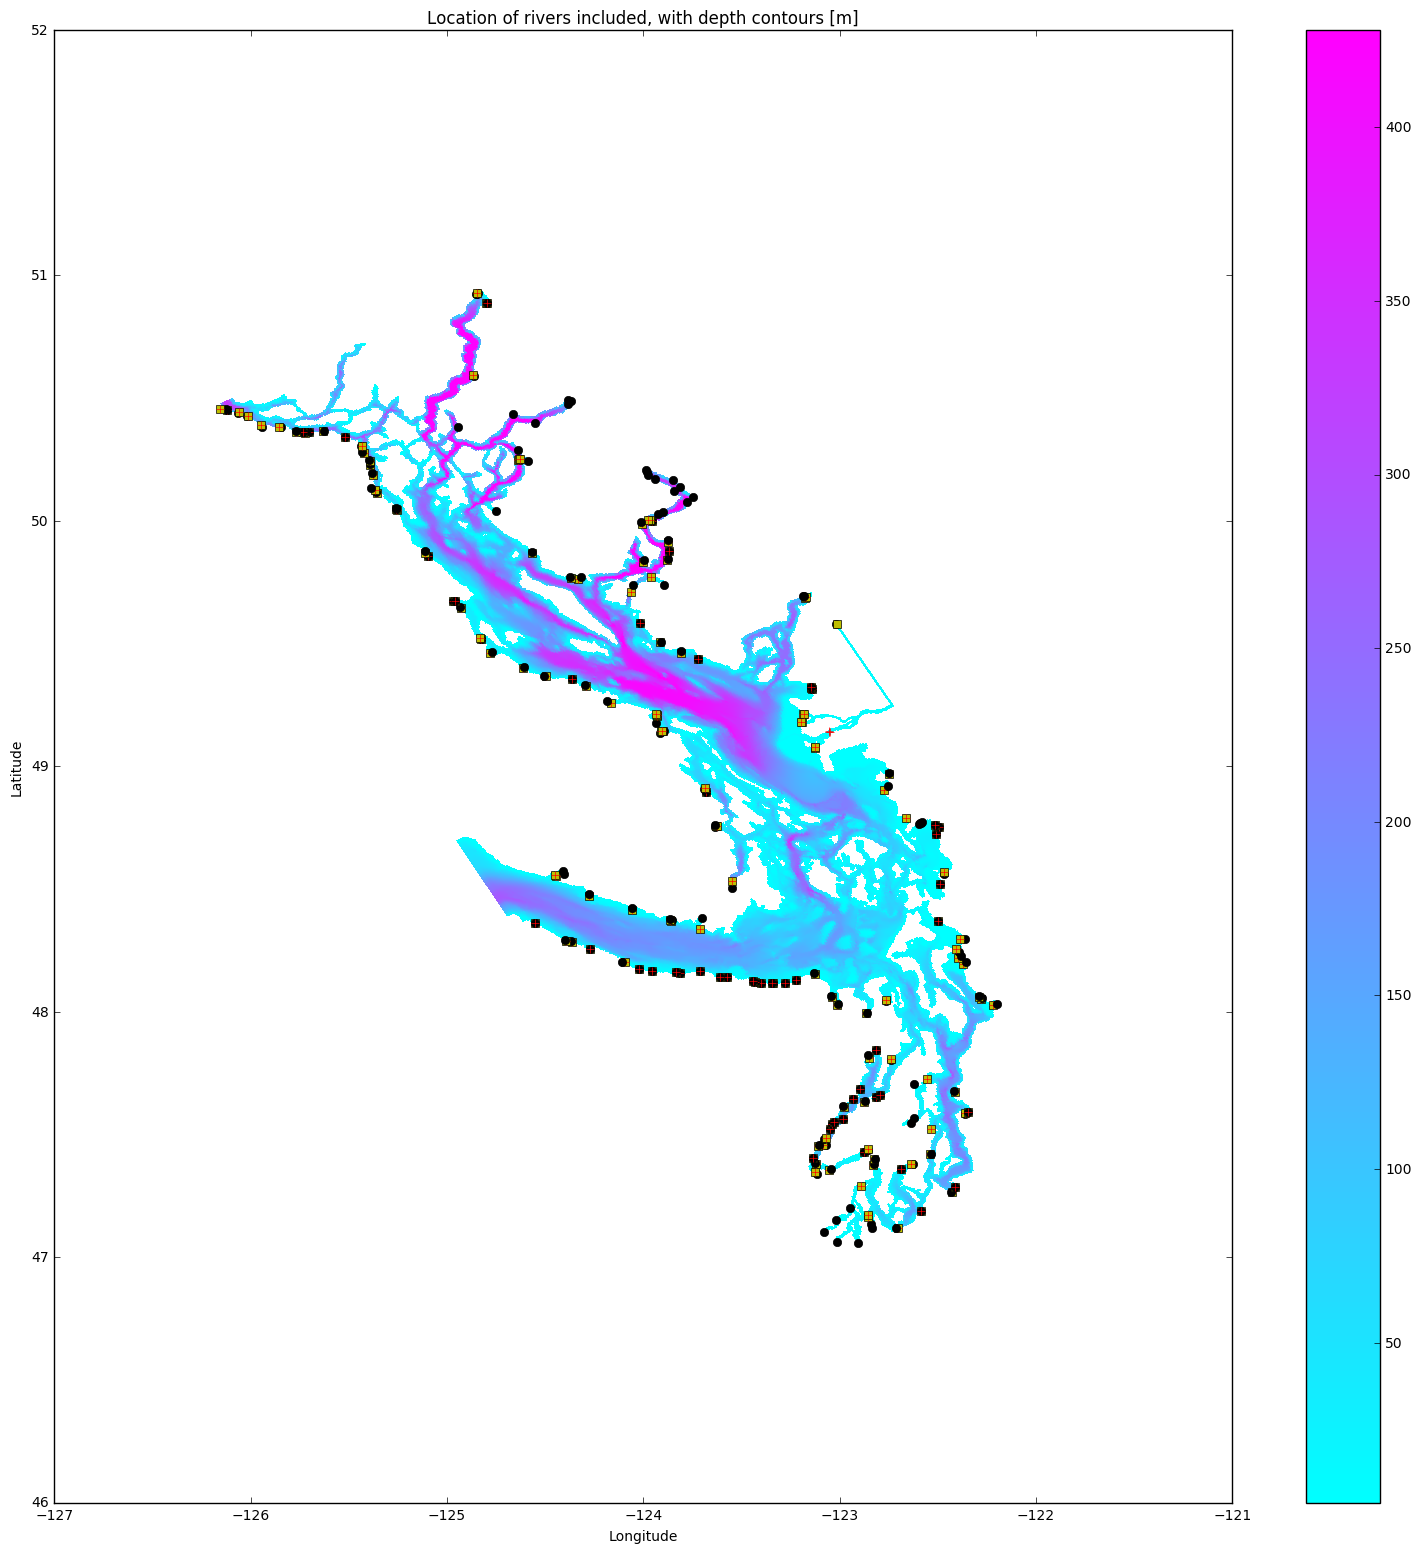

In [16]:
%matplotlib inline
Fraser = 8.10384 * e1t[500, 395] * e2t[500, 395]
test = NC.Dataset('../../../NEMO-forcing/rivers/rivers_cnst_201702.nc','r')
test2 = NC.Dataset('../../../NEMO-forcing/rivers/rivers_cnst_extended.nc', 'r')
test3 = NC.Dataset('../../../NEMO-forcing/rivers/rivers_cnst.nc', 'r')

plotting = test.variables['rorunoff'][0, :, :]
plot2 = test2.variables['rorunoff'][0, :, :]
orig = test3.variables['rorunoff'][0, :, :]

plt.figure(figsize=(19, 19))
plt.pcolormesh(lon[:], lat[:], D, cmap='cool')
sumit1 = 0.
sumit2 = 0.
sumit3 = 0.
for i in range(898):
    for j in range(398):
        if plot2[i, j] > 0:
            plt.plot(lon[i,j], lat[i,j],'ys')  #down by one two
        if plotting[i, j] > 0:
            plt.plot(lon[i,j], lat[i,j], 'ko')  # new
        if orig[i, j] > 0:
            plt.plot(lon[i,j], lat[i,j], 'r+')   # orig
#        if plot2[i, j] != plotting[i, j] or plot2[i, j] != orig[i, j] or plotting[i, j] != orig[i, j]:
#            sumit1 += e1t[i, j] * e2t[i, j] * plotting[i, j]/Fraser
#            sumit2 += e1t[i, j] * e2t[i, j] * plot2[i, j]/Fraser
#            sumit3 += e1t[i, j] * e2t[i, j] * orig[i ,j]/Fraser
#            print (i, j, e1t[i, j] * e2t[i, j] * plotting[i, j]/Fraser,
#                   e1t[i, j] * e2t[i, j] * plot2[i, j]/Fraser, 
#                   e1t[i, j] * e2t[i, j] * orig[i, j]/Fraser, sumit1, sumit2, sumit3)
            
plt.colorbar()
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Location of rivers included, with depth contours [m]')
plt.savefig('river_locations.pdf')


In [13]:
6.07788/8.10384

0.75

In [14]:
temp = test2.variables['rotemper'][:]
roro = test2.variables['rorunoff'][:]
print (temp.shape)
plt.plot(temp[:,351,345])
print (temp.max())

KeyError: 'rotemper'

In [ ]:
if rivertype == 'monthly':
    depths = D[roro[0] > 0.]
    ii, jj = np.where(roro[0] > 0.)
elif rivertype == 'constant':
    depths = D[roro > 0.]
    ii, jj = np.where(roro > 0.)

In [ ]:
print (ii[depths.mask], jj[depths.mask])
ip = ii[depths.mask]; jp = jj[depths.mask]

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.pcolormesh(D)
ax.plot(jp[0], ip[0],'mo')
ax.set_xlim((35, 65))
ax.set_ylim((870, 898))
ax.plot(45+0.5, 891+0.5,'r*')

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.pcolormesh(D)
ax.plot(jp[:3], ip[:3],'mo')
ax.set_xlim((300, 320))
ax.set_ylim((635, 655))
ax.plot(307+0.5, 651+0.5,'r*')
ax.plot(309+0.5, 650+0.5,'r*')
ax.plot(310+0.5, 649+0.5,'r*')

In [24]:
test.close()
test2.close()
nemo.close()

NameError: name 'nemo' is not defined

In [25]:
test = NC.Dataset('/results/forcing/rivers/RLonFraCElse_y2017m05d13.nc.aside')
test2 = NC.Dataset('/results/forcing/rivers/junk_RLonFraCElse_y2017m05d13.nc')

runoff = test.variables['rorunoff'][:]
new_runoff = test2.variables['rorunoff'][:]
print(np.max(runoff), np.max(new_runoff))
print(np.min(runoff-new_runoff), np.max(runoff-new_runoff))


22.9068 22.9068
-1.86265e-09 5.96046e-08


In [26]:
print (runoff.shape)

(1, 898, 398)


In [27]:
print(runoff[0, 500, 395]-22.9068)

3.93707275386e-05


In [28]:
print(new_runoff[0, 500, 395]-22.9068)

3.93707275386e-05


In [29]:
!ls -l /results/forcing/rivers/RLonFraCElse_y2017m05d13.nc.aside

-rw-r--r-- 1 dlatorne sallen 33828 May 14 05:58 /results/forcing/rivers/RLonFraCElse_y2017m05d13.nc.aside


In [30]:
!ls -l /results/forcing/rivers/junk_RLonFraCElse_y2017m05d13.nc

-rw-r--r-- 1 sallen sallen 14220 May 14 20:11 /results/forcing/rivers/junk_RLonFraCElse_y2017m05d13.nc
